In [1]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.set_printoptions(precision=4, suppress=True)

## Q1 (25 points): Outlier Detection and Removal Using Cook's Distance

In [2]:
# ============================================================
# Load dataset
# ============================================================

df = pd.read_csv("usina_with_outliers.csv")

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())
display(df.head())

Shape: (9568, 5)

Columns:
['AT', 'V', 'AP', 'RH', 'PE']


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


## Q1.1 Model Choice and Justification (10 points)

### What model did I choose and why?
I chose to implement a linear regression model, as it is the regression model that I am most comfortable with. I realized that, with the data having multiple features, a Ridge or Lasso regression could have been more appropriate, as there is the chance of multicollinearity or a need for the model to be simplified. However, I wanted to start out with Linear to warm-myself-up for the more complex regression that is coming up throughout the homework! Also, cook's distance is defined for OLS, whereas Ridge or Lasso change introduce bias to the coefficients, hindering the interpretability of Cook's distance. 

### What library did I choose and why?
I chose the statsmodles OLS library since it is the cleanest and safest choice for my use. It has Cook's Distance built in, which is easily accessed through the influence diagnostics. This makes the computation of outliers and their removal straight forward. With, scikit-learn, I believe I would have to mannually compute Cook's Distance, which is time taking and error-prone. 

In [3]:
def fit_ols_diagnostics(X, y):
    """Fit OLS and return (model, diagnostics dataframe).

    Parameters
    ----------
    X : array-like, shape (n,) or (n, p)
        Feature matrix (without intercept column).
    y : array-like, shape (n,)
        Target vector.
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Add intercept column for statsmodels
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()

    infl = OLSInfluence(model)
    diag = pd.DataFrame({
        "y": y,
        "y_hat": model.fittedvalues,
        "residual": model.resid,
        "leverage_hii": infl.hat_matrix_diag,   # diagonal of Hat matrix H
        "cooks_D": infl.cooks_distance[0]
    })
    return model, diag

def plot_line_fit(y, model, title=""):
    """Scatter + fitted line for 1D x."""
    y = np.asarray(y).reshape(-1)
    idx = np.arange(1, len(y) + 1)

    plt.figure(figsize=(7, 4))
    plt.scatter(idx, y, label="Observed")

    yhat = model.fittedvalues
    plt.plot(idx, yhat, label="OLS fit")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [4]:
def prepare_xy(df_in, target_col):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     4416.
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:59:22   Log-Likelihood:                -36621.
No. Observations:                9568   AIC:                         7.325e+04
Df Residuals:                    9563   BIC:                         7.329e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.7845     19.524      2.447      0.0

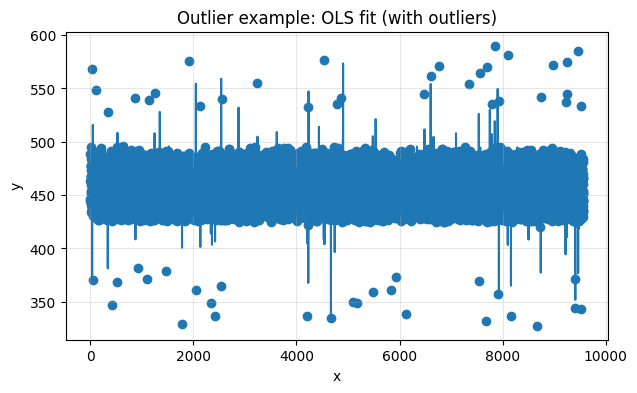

In [5]:
x, y = prepare_xy(df, target_col="PE")
model_full, diag_full = fit_ols_diagnostics(x, y)

print(model_full.summary())
plot_line_fit(y, model_full, title="Outlier example: OLS fit (with outliers)")

## Q1.2 Identify outliers, remove them, and export clean CSV (15 points)

### 1. Compute Cook's Distance for each data point
### 2. Determine outliers with the appropriate threshold rule (4/n)
### 3. Remove the outliers and export this clean dataste to a new CSV file named: **usina.csv**

In [6]:
# Show the top points by Cook's distance
threshold = 4 / float(len(x))
diag_table = diag_full.copy()
diag_table = pd.concat([diag_full.reset_index(drop=True),
                        x.reset_index(drop=True)], axis=1)
diag_table["flag_D_gt_4_over_n"] = diag_table["cooks_D"] > threshold
print(f"Cook's distance heuristic threshold 4/n = {threshold:.6f}")
diag_table.sort_values("cooks_D", ascending=False)


Cook's distance heuristic threshold 4/n = 0.000418


,y,y_hat,residual,leverage_hii,cooks_D,AT,V,AP,RH,flag_D_gt_4_over_n
4228,532.89197,367.627618,165.264352,0.027485,1.283760e+00,73.964839,155.117358,1047.682702,171.881613,True
49,370.64803,515.833750,-145.185720,0.027817,1.003422e+00,-35.324839,116.357358,1064.772702,164.891613,True
875,541.43197,408.524788,132.907182,0.032505,9.921334e-01,67.814839,-10.197358,984.647298,168.221613,True
5922,373.10803,481.504793,-108.396763,0.041859,8.665161e-01,-35.034839,114.407358,979.907298,-7.931613,True
2538,364.32803,559.133964,-194.805934,0.013496,8.512237e-01,-29.834839,-33.967358,1042.892702,-16.301613,True
...,...,...,...,...,...,...,...,...,...,...
3893,441.00000,440.997993,0.002007,0.000596,3.889632e-12,27.940000,63.070000,1010.750000,38.570000,False
3390,451.29000,451.291688,-0.001688,0.000345,1.588981e-12,18.340000,65.940000,1013.270000,85.420000,False
2699,460.19000,460.188889,0.001111,0.000406,8.105201e-13,15.790000,50.880000,1014.580000,99.900000,False
7072,475.21000,475.210337,-0.000337,0.000423,7.765671e-14,9.820000,36.180000,1019.180000,65.800000,False


In [7]:
df_clean = diag_table.loc[diag_table["flag_D_gt_4_over_n"] == False].copy()
df_clean = df_clean.rename(columns={"y":"PE"})
df_clean = df_clean[list(df.columns)]
df_clean = df_clean.reset_index(drop=True)
df_clean

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9443,16.65,49.69,1014.01,91.00,460.03
9444,13.19,39.18,1023.67,66.78,469.62
9445,31.32,74.33,1012.92,36.48,429.57
9446,24.48,69.45,1013.86,62.39,435.74


In [8]:
df_clean.to_csv("usina.csv", index=False)

## Q2 Train/Test Evaluation Before vs After Outlier Removal (20 points)

#### Train Linear Regression, Ridge Regression, and Lasso Regression on usina_with_outliers.csv and on usina.csv. Report train/test metrics. For Ridge and Lasso, use lambda values {0.01, 0.1, 1, 10, 100}

In [9]:
target_col = "PE"

In [10]:
# split dataset with outliers
X = df.drop(columns=[target_col]).copy()
y = df[target_col].values.reshape(-1, 1)

X_train_w_outliers, X_test_w_outliers, y_train_w_outliers, y_test_w_outliers = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

print("Train:", X_train_w_outliers.shape, y_train_w_outliers.shape)
print("Test :", X_test_w_outliers.shape, y_test_w_outliers.shape)


Train: (6697, 4) (6697, 1)
Test : (2871, 4) (2871, 1)


In [11]:
# split dataset without outliers
X = df_clean.drop(columns=[target_col]).copy()
y = df_clean[target_col].values.reshape(-1, 1)

X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

print("Train:", X_train_no_outliers.shape, y_train_no_outliers.shape)
print("Test :", X_test_no_outliers.shape, y_test_no_outliers.shape)

Train: (6613, 4) (6613, 1)
Test : (2835, 4) (2835, 1)


In [12]:
def eval_metrics(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return {
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2":  r2_score(y_true, y_pred),
    }

def standardized_coef_unscaled(beta, X_train_raw, y_train_raw):
    """Standardized coefficients (effect size) for unscaled data:
       beta_std = beta * (std(X)/std(y)), computed using TRAIN statistics.
    """
    std_x = np.std(X_train_raw, axis=0, ddof=0)
    std_y = float(np.std(y_train_raw, axis=0, ddof=0))
    std_y = std_y if std_y > 0 else 1.0
    return beta * (std_x / std_y)

def fit_and_report_linear_models():
    models_w_outliers = {
        "Linear with outliers": LinearRegression(),
    }

    rows = []

    for name, model in models_w_outliers.items():
        model.fit(X_train_w_outliers, y_train_w_outliers.ravel())
        pred_tr = model.predict(X_train_w_outliers).reshape(-1,1)
        pred_te = model.predict(X_test_w_outliers).reshape(-1,1)
        mtr = eval_metrics(y_train_w_outliers, pred_tr)
        mte = eval_metrics(y_test_w_outliers, pred_te)

        rows.append({
            "model": name,
            **{f"train_{k}": v for k,v in mtr.items()},
            **{f"test_{k}": v for k,v in mte.items()},
        })

        models_no_outliers = {
            "Linear no outliers": LinearRegression(),
        }

        for name, model in models_no_outliers.items():
            model.fit(X_train_no_outliers, y_train_no_outliers.ravel())
            pred_tr = model.predict(X_train_no_outliers).reshape(-1,1)
            pred_te = model.predict(X_test_no_outliers).reshape(-1,1)
            mtr = eval_metrics(y_train_no_outliers, pred_tr)
            mte = eval_metrics(y_test_no_outliers, pred_te)

            rows.append({
                "model": name,
                **{f"train_{k}": v for k,v in mtr.items()},
                **{f"test_{k}": v for k,v in mte.items()},
            })
    return pd.DataFrame(rows)

In [13]:
lambda_grid = np.array([0.01, 0.1, 1, 10, 100])

In [14]:
def sweep_model(model_type: str, lambda_grid: np.ndarray):
    rows = []
    for lam in lambda_grid:
        if model_type == "Ridge":
            model = Ridge(alpha=lam, random_state=42)
        elif model_type == "Lasso":
            model = Lasso(alpha=lam, max_iter=50000, random_state=42)

        model.fit(X_train_w_outliers, y_train_w_outliers.ravel())
        pred_tr = model.predict(X_train_w_outliers).reshape(-1,1)
        pred_te = model.predict(X_test_w_outliers).reshape(-1,1)
        mtr = eval_metrics(y_train_w_outliers, pred_tr)
        mte = eval_metrics(y_test_w_outliers, pred_te)

        rows.append({
            "model": model_type,
            "outliers": "Y",
            "lambda": float(lam),
            **{f"train_{k}": v for k,v in mtr.items()},
            **{f"test_{k}": v for k,v in mte.items()},
        })

        model.fit(X_train_no_outliers, y_train_no_outliers.ravel())
        pred_tr = model.predict(X_train_no_outliers).reshape(-1,1)
        pred_te = model.predict(X_test_no_outliers).reshape(-1,1)
        mtr = eval_metrics(y_train_no_outliers, pred_tr)
        mte = eval_metrics(y_test_no_outliers, pred_te)

        rows.append({
            "model": model_type,
            "outliers": "N",
            "lambda": float(lam),
            **{f"train_{k}": v for k,v in mtr.items()},
            **{f"test_{k}": v for k,v in mte.items()},
        })
    return pd.DataFrame(rows)

In [15]:
# --- Linear ---
part1_results = fit_and_report_linear_models()
display(part1_results.sort_values(["test_mse"]).sort_index())

,model,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,Linear with outliers,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
1,Linear no outliers,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302


In [16]:
# --- Lasso ---
lasso = sweep_model("Lasso", lambda_grid)
display(lasso.sort_values(by="outliers"))

,model,outliers,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
1,Lasso,N,0.01,19.864675,3.596368,0.931369,20.396738,3.624754,0.930302
3,Lasso,N,0.10,19.865263,3.596855,0.931367,20.392600,3.624890,0.930316
5,Lasso,N,1.00,19.929852,3.605523,0.931144,20.414755,3.631153,0.930241
7,Lasso,N,10.00,25.685683,4.086632,0.911258,26.157253,4.120464,0.910618
9,Lasso,N,100.00,132.056336,9.482307,0.543756,132.148253,9.523550,0.548436
0,Lasso,Y,0.01,123.384210,5.198858,0.650171,125.115332,5.052626,0.642568
2,Lasso,Y,0.10,123.384607,5.201739,0.650169,125.134495,5.055348,0.642514
4,Lasso,Y,1.00,123.421151,5.229507,0.650066,125.338356,5.083092,0.641931
6,Lasso,Y,10.00,126.141514,5.540418,0.642353,128.902136,5.408803,0.631750
8,Lasso,Y,100.00,234.655937,11.285489,0.334683,233.064336,11.258653,0.334178


In [17]:
# --- Ridge ---
ridge = sweep_model("Ridge", lambda_grid)
display(ridge.sort_values(by="outliers"))

,model,outliers,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
1,Ridge,N,0.01,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
3,Ridge,N,0.10,19.864671,3.596397,0.931369,20.396770,3.624773,0.930302
5,Ridge,N,1.00,19.864671,3.596400,0.931369,20.396750,3.624774,0.930302
7,Ridge,N,10.00,19.864672,3.596430,0.931369,20.396549,3.624783,0.930303
9,Ridge,N,100.00,19.864758,3.596742,0.931369,20.394626,3.624880,0.930310
0,Ridge,Y,0.01,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
2,Ridge,Y,0.10,123.384207,5.198680,0.650171,125.113392,5.052459,0.642574
4,Ridge,Y,1.00,123.384207,5.198685,0.650171,125.113421,5.052463,0.642574
6,Ridge,Y,10.00,123.384207,5.198737,0.650171,125.113705,5.052513,0.642573
8,Ridge,Y,100.00,123.384213,5.199261,0.650171,125.116548,5.053003,0.642565


## Q2 Discussion

### 1. Do outliers change train error? Test error?
Outliers affect both train error and test error for all three of the models. If we look at Train R² for the models trained on the dataset with outliers, we see an average of 0.65. Now, if we look at the Train R² for the models trained on the dataset without outliers, we see an average of 0.93, which is signficantly higher than the Train R² with outliers. Looking at the Test R² for the models trained on the dataset with outliers, we see an average of 0.64. Now, if we look at the Test R² for the models trained on the dataset without outliers, we see an average of 0.93, which is signficantly higher than the Test R² with outliers. These metrics are enough to conclude that outliers affect the train and test error for the models trained on this dataset.

### 2. Which dataset shows better generalization?
Without a doubt, the dataset without outleirs has better generalization. The Test R² are all substantially greater for models trained on the dataset without outliers. Hence, these models are better suited for accurately predicting the Power Output of unseen data.

### 3. Do Ridge/Lasso appear to help relative to standard linear regression?
Ridge and Lasso don't appear to help increase the accuracy of prediction for the models relative to linear regression. For the dataset without outliers, Linear Regression shows a Test R² of 0.93, which almost all of the Ridge and Lasso models output as well. The trend is upheld for the dataset with outliers as well. The only difference I noticed was that the Lasso model with a lambda of 100 had a Test R² of 0.55, which could indicate that Lasso's performance could deteriorate at extremely high lambda values. 

It is important to note that the lambda values that we tested are relatively low when compared to the magnitude of feature values. If we had tested over a range of lambdas of higher magnitude, we would have seen a clear drop in model performance. 

## Q3 Reliability of Coefficients (Using Outlier-Removed Dataset)

### 1. Why did I choose Linear Regression as my model?
I chose Linear Regression as my model because it was the easiest to denote coefficients as reliable or not. Simply by evaluating the t-statistics of all of the coefficients computed, can the ranking of reliability of the coefficients be computed. Furthermore, the t-statistic can be used to classify coefficients as meaningful (large t) or mostly noise (t near 0). If any coefficient has a t-statistic absolute value greater than 2, it often suggests that it is statistically significant.

### 2. Why did I choose statsmodels learn as my library?
I stuck with statsmodels because it directly provides t and p values which are metrics that I was planning to use to evaluate the reliability of coefficients. With the function sm.OLS I get easy access to these metrics, whereas I would have to directly compute them in sklearn. 

### 3. Would I scale IVs and/or DV for this coefficient reliability task?
I did not scale the IV or the DV for this coefficient reliability task. Since we are dealing with t and p values and they are not effected by scaling, I didn't find the need to scale since it wouldn't provide any benefit. Scaling the independent variable would not result in a change of t values. Likewise, scaling the dependent variable would not skew the reliability of the coefficients, and would instead end up just changing the units of the metrics. For these reasons, I found it unnecesary to scale either variable. 

In [18]:
feature_names = X_train_no_outliers.columns.tolist()
def linear_with_ols_reports():
    reports = {}
    Xt_tr, Xt_te = X_train_no_outliers, X_test_no_outliers
    yt_tr = y_train_no_outliers

    lr = LinearRegression()
    lr.fit(Xt_tr, yt_tr.ravel())

    pred_tr = lr.predict(Xt_tr).reshape(-1,1)
    pred_te = lr.predict(Xt_te).reshape(-1,1)

    mtr = eval_metrics(y_train_no_outliers, pred_tr)
    mte = eval_metrics(y_test_no_outliers, pred_te)

    # OLS (t-stats)
    X_sm = sm.add_constant(Xt_tr)
    ols = sm.OLS(yt_tr, X_sm).fit()

    feat_names = ["const"] + feature_names
    ols_table = pd.DataFrame({
        "term": feat_names,
        "beta_hat": ols.params.to_numpy(),
        "t_value": ols.tvalues.to_numpy(),
        "p_value": ols.pvalues.to_numpy()
    }).sort_values("t_value", key=np.abs, ascending=False)

    # Standardized coefficients
    beta = lr.coef_.reshape(-1)
    beta_std = standardized_coef_unscaled(beta, X_train_no_outliers, y_train_no_outliers)
    coef_table = pd.DataFrame({
        "feature": feature_names,
        "coef_value": beta,
        "standardized_coef": beta_std
    }).sort_values("standardized_coef", key=np.abs, ascending=False)

    reports["Linear Regression Unscaled"] = {
        "train_metrics": mtr,
        "test_metrics": mte,
        "coef_table": coef_table,
        "ols_table": ols_table
    }
    return reports

lin_reports = linear_with_ols_reports()

/var/folders/jz/m68wtgq93j7gs2bmff9jgdcr0000gn/T/ipykernel_10278/3759509390.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std_y = float(np.std(y_train_raw, axis=0, ddof=0))


In [19]:
print("\nOLS t-statistics (studentized coefficients):")
display(lin_reports["Linear Regression Unscaled"]["ols_table"].sort_values(by="t_value"))


OLS t-statistics (studentized coefficients):


,term,beta_hat,t_value,p_value
1,AT,-1.966193,-108.971834,0.000000e+00
4,RH,-0.150944,-31.237663,6.360165e-200
2,V,-0.234557,-27.390969,1.487453e-156
3,AP,0.072105,6.438038,1.295207e-10
0,const,443.753358,38.455715,3.717392e-292


### Q3.2 Results
To evaluate the reliability of coefficients in the Linear Regression model, we must find a way to measure how confidently a coefficient differs from 0. Studentizatioin scales coefficients by the reciprocal of its uncertainty, producing the t-statistic that can be used towards determining if coefficients are likely signal vs likely noise. Coefficients with a t-statistic near 0 could be mostly noise, whereas those with a t-statistic of large magnitude inidicate that it is likely meaningful. Therefore, the larger the t-value the more reliable the coefficient is. This makes the **Ambient Temperature** coefficient the most reliable, since it has the larges t-statistic out of all the coefficients. On the other hand, **Ambient Pressure**'s coefficient is the least reliable, since it has the smallest t-value out of all the coefficients. Note, however, that although it is the least reliable, the general threshold of |t| > 2 indicates that this coefficient is statistically significant. Therefore, Ambient Pressure, may not for surely be unmeaningful, or mostly noise. 

## Q4.1 (20 points): Most Important vs Least Important Features (Using Outlier-Removed Dataset)

### 1. Why did I choose Lasso as my model?
I chose the Lasso model for testing the importance of coefficients because the model with a lambda = 0.1 had the best Test R² out of all the models computed previously. With the best Test R², this model has the best capability for generalizing, deeming it the model with the highest accuracy of predicting the results of unforeseen data. Therefore, I found it appropriate to test this model, since it would likely be the one used to test new data. 

### 2. Why did I choose sci-kit learn as my library?
I went with scikit learn as my library because it has a built in Lasso regression function that makes computing a model really easy. Statsmodels focus mainly on basic linear regression, so I found the simple Lasso function that comes from the sklearn library super efficient. Additionally, it is the library that Dinuka chose to implement his Lasso regression, and my code is a simplified version of his :).

### 3. Would I scale IVs and/or DV for this feature importance task?
I would scale the DVs since it is considered to standardize Y values before performing Lasso. This is necessary because regularization penalties depend on the magnitude of coefficients, and since features have different scales, penalties become unfair. For this reason, standardizing the DVs is critical for Lasso Regression, as it will ensure that the coefficients for each feature are being judged on the same scale. This makes the shrinking of coefficients and feature selection meaningful and comparable. 

In [20]:
# Scaling the DVs
y_scaler = StandardScaler()
y_train_no_outliers = y_scaler.fit_transform(y_train_no_outliers)
y_test_no_outliers  = y_scaler.transform(y_test_no_outliers)

In [21]:
feature_names = X_train_no_outliers.columns.tolist()
def standardized_coeff_table(model):
    beta = model.coef_.reshape(-1)
    beta_std = standardized_coef_unscaled(beta, X_train_no_outliers, y_train_no_outliers)
    return pd.DataFrame({
        "feature": feature_names,
        "coef_value": beta,
        "standardized_coef": beta_std
    }).sort_values("standardized_coef", key=np.abs, ascending=False)

In [22]:
# Reusing sweep_model function. This time, y values for the no outliers dataset,
# the dataset relevant to this problem, are scaled as required by the question.

# --- Lasso ---
lambda_grid = np.array([0.1, 1, 2.5, 5, 10])
lasso = sweep_model("Lasso", lambda_grid)
lasso = lasso.loc[lasso["outliers"] == "N"]
display(lasso.sort_values(by="outliers"))

,model,outliers,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
1,Lasso,N,0.1,0.069287,0.212674,0.930713,0.070868,0.214060,0.929907
3,Lasso,N,1.0,0.103267,0.258535,0.896733,0.104538,0.259039,0.896607
5,Lasso,N,2.5,0.219821,0.371699,0.780179,0.218780,0.370113,0.783614
7,Lasso,N,5.0,0.397045,0.513655,0.602955,0.396211,0.514362,0.608126
9,Lasso,N,10.0,0.861998,0.799308,0.138002,0.870404,0.807818,0.139124


In [23]:
# --- Lasso (lambda = 0.1) ---
best_lam_lasso = lasso.iloc[0]["lambda"]
lasso_best_model = Lasso(alpha=best_lam_lasso, max_iter=50000, random_state=42).fit(X_train_no_outliers, y_train_no_outliers.ravel())

print("\nLasso (lambda = 0.1) standardized coefficients:")
display(standardized_coeff_table(lasso_best_model))


Lasso (lambda = 0.1) standardized coefficients:


/var/folders/jz/m68wtgq93j7gs2bmff9jgdcr0000gn/T/ipykernel_10278/3759509390.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std_y = float(np.std(y_train_raw, axis=0, ddof=0))


,feature,coef_value,standardized_coef
AT,AT,-0.110046,-0.819230
V,V,-0.015596,-0.198080
RH,RH,-0.007325,-0.108271
AP,AP,0.002923,0.017365


In [24]:
# --- Lasso (lambda = 1) ---
best_lam_lasso = lasso.iloc[1]["lambda"]
lasso_best_model = Lasso(alpha=best_lam_lasso, max_iter=50000, random_state=42).fit(X_train_no_outliers, y_train_no_outliers.ravel())

print("\nLasso (lambda = 1) standardized coefficients:")
display(standardized_coeff_table(lasso_best_model))


Lasso (lambda = 1) standardized coefficients:


/var/folders/jz/m68wtgq93j7gs2bmff9jgdcr0000gn/T/ipykernel_10278/3759509390.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std_y = float(np.std(y_train_raw, axis=0, ddof=0))


,feature,coef_value,standardized_coef
AT,AT,-0.068775,-0.511992
V,V,-0.028334,-0.359857
AP,AP,0.000000,0.000000
RH,RH,0.000000,0.000000


In [25]:
# --- Lasso (lambda = 2.5) ---
best_lam_lasso = lasso.iloc[2]["lambda"]
lasso_best_model = Lasso(alpha=best_lam_lasso, max_iter=50000, random_state=42).fit(X_train_no_outliers, y_train_no_outliers.ravel())

print("\nLasso (lambda = 2.5) standardized coefficients:")
display(standardized_coeff_table(lasso_best_model))


Lasso (lambda = 2.5) standardized coefficients:


/var/folders/jz/m68wtgq93j7gs2bmff9jgdcr0000gn/T/ipykernel_10278/3759509390.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std_y = float(np.std(y_train_raw, axis=0, ddof=0))


,feature,coef_value,standardized_coef
V,V,-0.042527,-0.540118
AT,AT,-0.021275,-0.158383
AP,AP,0.000000,0.000000
RH,RH,0.000000,0.000000


In [26]:
# --- Lasso (lambda = 5) ---
best_lam_lasso = lasso.iloc[3]["lambda"]
lasso_best_model = Lasso(alpha=best_lam_lasso, max_iter=50000, random_state=42).fit(X_train_no_outliers, y_train_no_outliers.ravel())

print("\nLasso (lambda = 5) standardized coefficients:")
display(standardized_coeff_table(lasso_best_model))


Lasso (lambda = 5) standardized coefficients:


/var/folders/jz/m68wtgq93j7gs2bmff9jgdcr0000gn/T/ipykernel_10278/3759509390.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std_y = float(np.std(y_train_raw, axis=0, ddof=0))


,feature,coef_value,standardized_coef
V,V,-0.037551,-0.476917
AT,AT,-0.000000,-0.000000
AP,AP,0.000000,0.000000
RH,RH,0.000000,0.000000


### Q4.2 Results
Results were derived by computing the Lasso Regression for lambda values of 0.1, 1, 2.5, and 5. Across the coefficients computed for all of these models, the ranking of standardized coefficients never changed. The highest was always **Ambient Temperature**, deeming it the most important feature in the model as it carries the most weight and influence. The lowest was consistently **Ambient Pressure**, meaning that this feature was the feature to carry the least weight in the model, and therefore the least important. 

## Q5 (15 points): Regularization Paths (Scaled Data, Outlier-Removed Dataset)

In [27]:
# Scaling the IVs and DVs
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_sc = x_scaler.fit_transform(X_train_no_outliers)
X_test_sc  = x_scaler.transform(X_test_no_outliers)

y_train_sc = y_scaler.fit_transform(y_train_no_outliers)
y_test_sc  = y_scaler.transform(y_test_no_outliers)

In [28]:
def sweep_model_scaled(model_type: str, lambda_grid: np.ndarray):
    rows = []
    for lam in lambda_grid:
        if model_type == "Ridge":
            model = Ridge(alpha=lam, random_state=42)
        elif model_type == "Lasso":
            model = Lasso(alpha=lam, max_iter=50000, random_state=42)

        model.fit(X_train_sc, y_train_sc.ravel())
        pred_tr = model.predict(X_train_sc).reshape(-1,1)
        pred_te = model.predict(X_test_sc).reshape(-1,1)
        mtr = eval_metrics(y_train_sc, pred_tr)
        mte = eval_metrics(y_test_sc, pred_te)

        beta = model.coef_
        rows.append({
            "model_type": model_type,
            "lambda": float(lam),
            "AT": beta[0],
            "V": beta[1],
            "AP": beta[2],
            "RH": beta[3],
        })
             
    return pd.DataFrame(rows)

In [29]:
coef_cols = ["AT", "V", "AP", "RH"]
def plot_coefficients_vs_lambda(model, model_name):
    plt.figure()
    for col in coef_cols:
        plt.plot(model["lambda"], model[col], label=col)

    plt.xscale("log")          # λ is logarithmic
    plt.xlabel("Lambda (λ)")
    plt.ylabel(model_name + " Coefficient value")
    plt.title(model_name + " Coefficient Paths")
    plt.legend()
    plt.show()

,model_type,lambda,AT,V,AP,RH
0,Lasso,0.010000,-0.833760,-0.180976,0.023858,-0.108353
1,Lasso,0.010476,-0.832480,-0.181264,0.023799,-0.107264
2,Lasso,0.010975,-0.831139,-0.181565,0.023736,-0.106123
3,Lasso,0.011498,-0.829735,-0.181881,0.023670,-0.104927
4,Lasso,0.012045,-0.828263,-0.182212,0.023601,-0.103675
...,...,...,...,...,...,...
95,Lasso,0.830218,-0.119704,-0.000000,0.000000,0.000000
96,Lasso,0.869749,-0.080173,-0.000000,0.000000,0.000000
97,Lasso,0.911163,-0.038759,-0.000000,0.000000,0.000000
98,Lasso,0.954548,-0.000000,-0.000000,0.000000,0.000000


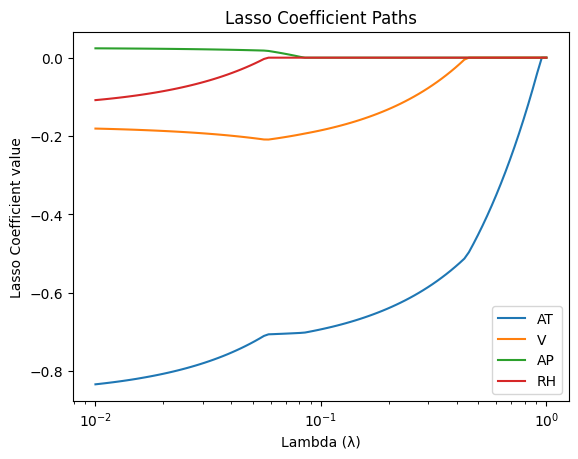

In [30]:
# --- Lasso ---
lambda_grid = np.logspace(-2, 0, 100)
lasso = sweep_model_scaled("Lasso", lambda_grid)
display(lasso.sort_values(by="lambda"))
plot_coefficients_vs_lambda(lasso, "Lasso")

,model_type,lambda,AT,V,AP,RH
0,Ridge,0.010000,-0.860345,-0.175107,0.025181,-0.131130
1,Ridge,0.011768,-0.860344,-0.175108,0.025181,-0.131129
2,Ridge,0.013849,-0.860343,-0.175108,0.025181,-0.131129
3,Ridge,0.016298,-0.860341,-0.175109,0.025182,-0.131128
4,Ridge,0.019179,-0.860339,-0.175111,0.025182,-0.131127
...,...,...,...,...,...,...
95,Ridge,52140.082880,-0.093728,-0.085480,0.049896,0.034997
96,Ridge,61359.072734,-0.082352,-0.075171,0.044174,0.031233
97,Ridge,72208.090184,-0.072070,-0.065831,0.038911,0.027702
98,Ridge,84975.343591,-0.062843,-0.057437,0.034119,0.024434


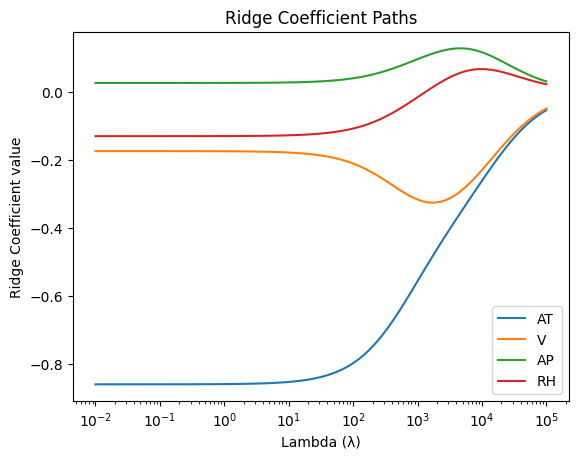

In [31]:
# --- Ridge ---
lambda_grid = np.logspace(-2, 5, 100)
ridge = sweep_model_scaled("Ridge", lambda_grid)
display(ridge.sort_values(by="lambda"))
plot_coefficients_vs_lambda(ridge, "Ridge")

## Q5 Discussion

### 1. What happens to coefficients as lambda increases in Ridge vs Lasso?
By looking at the plots of lambda vs the coefficient values for each model, the trends can be derived for coefficient behavior. In Lasso, the absolute value of all coefficients are shrunk to zero, and once the value starts to decrease it declines sharply. In Ridge however, we see that the absolute value of coefficients are smoothly shrunk to zero, avoiding any sharp declines that Lasso presents. 

### 2. Which regression is better under multicollinearity in IVs, and why?
Ridge is the regression that is better under multicollinearity because it spreads the weight across correlated features, instead of arbitrarily picking one to zero quickly. Ridge shrinks the coefficients that are correlated together, ensuring that they are balanced and stable. 

### 3. Which regression is better for feature selection, and why?
Lasso is the best regression for feature selection as it forces some coefficients to become exactly zero as lambda is increased. This mechanism is what makes Lasso a feature selection method, as it prefers a solution that uses fewer features, thereby simplifying the model. In the Lasso Graph, we can see how Ambient Temperature and Exhaust Vacuum are kept non-zero while Pressure and Humidity are zeroed earlier on the lambda scale, reflecting a selection of AT and V to stay on while AP and RH are turned off. 